# Random Interface Generation From Fault Inspired Power-Law
# Output two interfaces

Chris Field, January 2022

There is a considerable literature on a power-law behaviour relationship between a given fault throw and the number of faults having a throw greater than the given amount. We use this with a random Pareto distribution (which has the power law behaviour for large throws) to generate random interfaces. The faults have a dip of 45 degrees in this code.

* **pareto_throw:** Random number generation function with Pareto distribution and random +/-1 multiplier: pareto_throw function
    * The random numbers are the throws (or equivalently heaves) of our faults. Based on how random_interface works throw/heave is equivalent.
    * Random variables are added along the traverse, hence with a 1-to-1 scaling they would be at 45 degrees.
    * A horizontal vertical scaling can make the faults respect the Anderson faulting angle of 60 degrees.

* **random_interface:** Pass array of random numbers to random_interface function along with a starting depth
    * Generates the "random interface" by first creating an array by rounding the values of throw to the nearest integer and then creating that many grid cells with the sense of throw (negative or positive) and then performing a runing sum along the spatial grid of samples, this is our random interface

* **analysis_plot:** Pass random interface array to the plotting function, analysis_plot, along with a maximum depth paramter
    * Simple matplotlib wrapper for the input throws (random numbers), derived samples (what gets added for the random interface) and final samp_sum_list (the random interface)
    * Will create a better plotting function later just for the interface.

In [1]:
import os  # operating system
import sys # to add src directory for my modules
#
import numpy as np
import math
import random

from scipy import stats
from scipy import signal
#
# Plotting requirements
import matplotlib.pyplot as plt
import matplotlib.font_manager # different fonts
from matplotlib import rcParams # runtime config to set fonts

In [2]:
# Using rcParams set the global fonts for Matplotlib
# Global parameters for Matplotlib: set font etc.
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']
rcParams['font.serif'] = ['Garamond']
rcParams['font.size'] = '16'
#

Notes:
The SciPy stats probability density function for Pareto is defined for x >= 1. We need to move it back by 1 so it's >=0

## Input and Output

In [3]:
location_out='./Output/Pareto_fault_models/'
location_in = './Output/'

# If necessary make output folders
if not os.path.exists(location_out) :
    os.makedirs(location_out)

## Define functions

In [4]:
def pareto_throw(L=50, seed=42, b=5, shift=1, pos_def=True):
    """
    Generate random numbers for fault throws (equivalently heaves). 
    Plots a histogram of the generated random numbers and returns an array of the random throws.
    
    L -- cross-section length, number of random numbers, int
    seed -- random seed for random number generation, int
    b -- parameter for distribtion, corresponds to b for the Scipy Pareto distribution, float
    shift -- starting value for the probability distribution measure, we subtract this so values start from zero, float
    pos_def -- is the distribution positive definite? if so we need to randomly multiply some values by -1, Boolean
    """
    # Distrubtion properties
    mean, var, skew, kurt = stats.pareto.stats(b, moments='mvsk')
    print(f'Pareto distribution with parameter b={b} summary stats:\nMean: {mean}, var: {var}, skew: {skew}, kurt: {kurt}')

    # Set the distribution 
    distribution = stats.pareto(b)
    distribution.random_state = seed

    throws = distribution.rvs(size=L)

    # For Pareto we need to move it back so it starts from 0 not 1.
    #If the distriubtion is positive definite we need to make it alternating
    # the first sample has to stay positive -- it's the starting depth
    for j in range(len(throws)):
        throws[j] = throws[j] - shift
        throws[j] = throws[j]*random.randrange(-1, 2, 2)

    # Derived statistics
    print(f'\nOutput derived statistics:\n{stats.describe(throws)}\n')
    if stats.describe(throws).variance > 1000:
        print('WARNING!!: Variance is so high the results will probably not be meaningful.')

    # QC plot
    fig = plt.figure(figsize=(12,6)) 
    ax = fig.add_subplot(1,1,1)

    ax.hist(throws, bins='auto', color = '#ED1D24', alpha=0.6, rwidth=0.6)
    ax.set_title(f'Throw Histogram')
    # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    ax.tick_params(bottom=False, left=False)

    ## Add bar lines as a horizontal grid.
    ax.yaxis.grid(color='white')

    plt.tight_layout()

    # Show and save the graph
    plt.show()

    return throws

In [5]:
def random_interface(throws, D_int=25):
    """
    Create an interface from an array of ~"fault throws" (ideally derived from a statistical distribution).
    The fault throws/throws (throws) are presumed to be real numbers in the array/list throws
    
    Returns:
    samples -- an array indexed by the spatial step that tells us if we have positive, negative or no throw 
            on this spatial grid cell. It is created from rounding the values of throw to the nearest integer
            and then creating that many grid cells with the sense of throw (negative or positive)
    samp_sum_list -- running sum along the spatial grid of samples, this is our random interface
    
    Variables:
    throws -- an array or list of throws (ideally a series of random numbers)
    D_int -- starting depth (adds to the first throw value), int

    """
    # The random variables for the throw are in the list throw. We take its size so we now have far to iterate. 
    L = len(throws)
    
    # Samples is the spatial grid, indexed by i later.
    samples = [0] * 4*L
    # pad throws at the end
    throw_ext = [*throws, *samples]
    n = 0
    i =0

    # n will go through the throw array and i will index our new spatialised version of the throw
    while n < L:
        # If the throw from the throw list rounds to zero, simply move to the next grid
        # (leaving the throw to be added as zero).
        if int(round(throw_ext[n],0)) == 0:
            i += 1
        else:
            for j in range(int(round(abs(throw_ext[n]),0))):
                samples[i] = math.copysign(1,throw_ext[n])
                i += 1
                j += 1
        n += + 1
    # Limit samples to length L
    print(f'Final number of the random throw, n, is {n} and spatial grid, i, is {i}')
    samples = samples[:L]

    # Sum up the incremental fault throws
    samp_sum = D_int
    samp_sum_list = []
    for j in range(L):
        samp_sum += samples[j]
        samp_sum_list.append(samp_sum)
    
    return samples, samp_sum_list

In [6]:
def analysis_plot(throws, samples, samp_sum_list, D_total=50):
    """
    Plot the input throws, derived samples and final samp_sum_list
    
    throws -- an array or list of throws (ideally a series of random numbers)  
    samples -- an array or list on the spatial grid of throw of 1, 0, or -1 (derived from throws)
    samp_sum_list -- running sum along the spatial grid of samples, this is our random interface
    D_total -- maximum depth to plot for the random interface plot
    """
    x = np.arange(len(throws)) 
    # plot
    fig, axs = plt.subplots(ncols=3, sharey=False, figsize=(18, 6))

    axs[0].set_title('throws')
    axs[0].scatter(x, throws, linewidth=2.5)
    axs[0].set_ylim([4,-4])
    plt.gca().invert_yaxis()

    axs[1].set_title('Samples')
    axs[1].scatter(x, samples, linewidth=2.5)
    axs[1].set_ylim([4,-4])
    plt.gca().invert_yaxis()

    axs[2].set_title('Samp_sum_list')
    axs[2].step(x, samp_sum_list, linewidth=2.5)
    axs[2].set_ylim([0,D_total])
    plt.gca().invert_yaxis()

    plt.show()

In [7]:
def single_plot(samp_sum_list, D_total=50, title='Samp_sum_list'):
    """
    Plot the input throws, derived samples and final samp_sum_list
    
    throws -- an array or list of throws (ideally a series of random numbers)  
    samples -- an array or list on the spatial grid of throw of 1, 0, or -1 (derived from throws)
    samp_sum_list -- running sum along the spatial grid of samples, this is our random interface
    D_total -- maximum depth to plot for the random interface plot
    """
    x = np.arange(len(samp_sum_list)) 
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Depth (m)')
    
    ax.step(x, samp_sum_list, linewidth=2.5, alpha=0.9, color='#d62728')
    ax.set_ylim([0,D_total])
    plt.gca().invert_yaxis()

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    # ax.tick_params(bottom=False, left=False)

    ## Add bar lines as a horizontal grid.
    # ax.yaxis.grid(color='white')

    plt.tight_layout()
    
    plt.show()

In [8]:
def psd_and_slope_plot(topography_array):
    """
    Takes in an array that is the topographic profile (for example the random interface),
    derives Power Spectral Density,
    does a regression to get the slop
    plots the power spectral density and the regression 
    """
    # Look at the power spectral density
    freqs, psd = signal.periodogram(topography_array)

    # Do a regression and work out the slope
    res = stats.linregress(np.log10(freqs[1:-2000]), np.log10(psd[1:-2000]))
    print(res)
    print(f'The slope is {round(res.slope,2)}')

    # Start plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    # log x and y axis
    ax.plot(np.log10(freqs[1:-1]), np.log10(psd[1:-1]), alpha =0.6, color='#1f77b4', solid_capstyle="butt", lw=3)

    label = 'Slope = ' + str(round(res.slope,2))
    ax.plot(np.log10(freqs[1:-2000]), res.intercept + res.slope*np.log10(freqs[1:-2000]),  alpha=0.95, color='grey', 
            linewidth=3)

    ax.text(-1, 4 , label, color='grey')

    ax.set(title='Periodogram Power Spectral Density versus Wave Number')
    ax.set_xlabel('Log(k)')
    ax.set_ylabel('Log(Power)')

    # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    # ax.tick_params(bottom=False, left=False)

    ## Add bar lines as a horizontal grid.
    # ax.yaxis.grid(color='white')

    plt.tight_layout()

    # Show and save the graph
    plt.show()

## Create Interfaces
* We run through the workflow with values of the Pareto paramter, b=1.5 and b=2.0.

_________________________________________________________________________________________________________

In [9]:
b = 1.5
print(f'Creating interface with fault throw Pareto distribution with b={b}')

Creating interface with fault throw Pareto distribution with b=1.5


Pareto distribution with parameter b=1.5 summary stats:
Mean: 3.0, var: inf, skew: nan, kurt: nan

Output derived statistics:
DescribeResult(nobs=10000, minmax=(-231.36213123607723, 158.8481143271741), mean=-0.02791558034369217, variance=38.74386980929524, skewness=-4.468000274786331, kurtosis=414.183562260968)



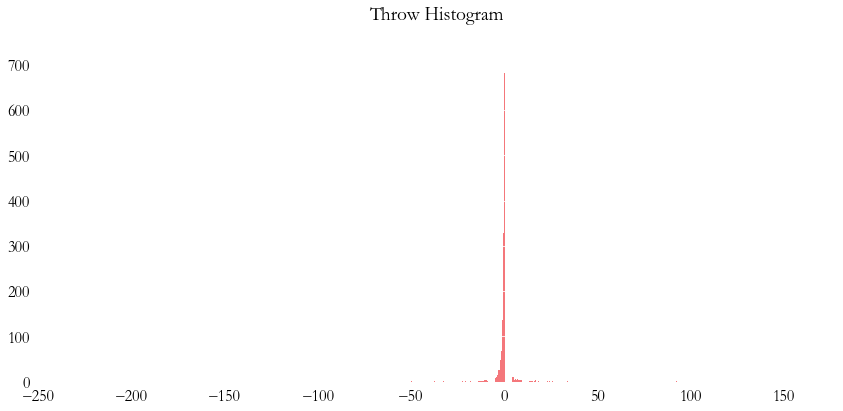

Final number of the random throw, n, is 10000 and spatial grid, i, is 21506


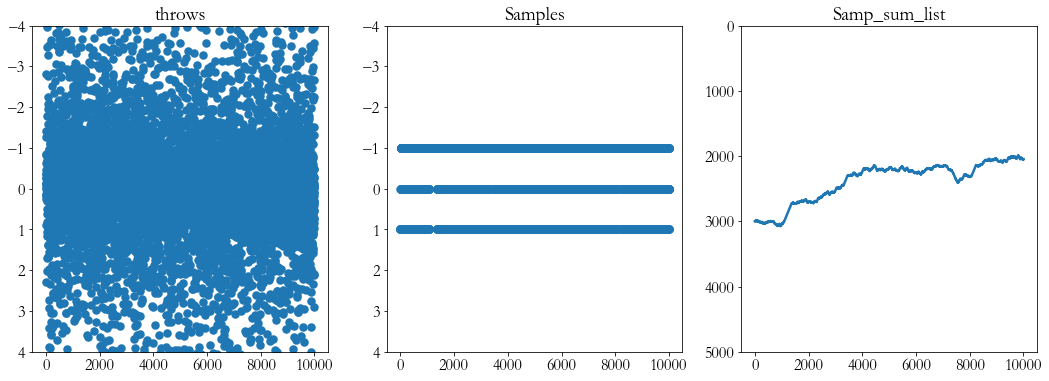

In [10]:
throws = pareto_throw(L=10000, seed=42, b=b, shift=1, pos_def=True)
samples, samp_sum_list = random_interface(D_int=3000, throws=throws)
analysis_plot(throws, samples, samp_sum_list, D_total=5000)

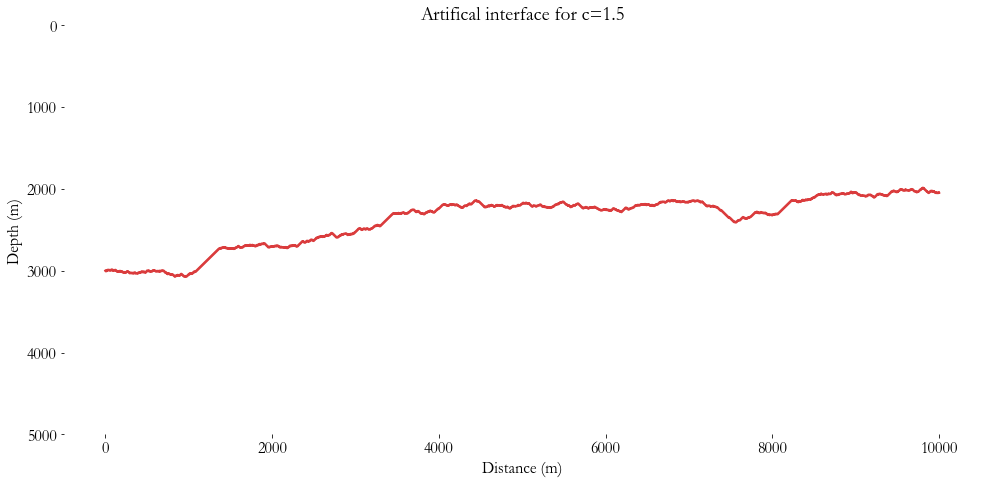

In [11]:
title = 'Artifical interface for c=' + str(b)
single_plot(samp_sum_list, D_total=5000, title=title)

In [12]:
# Statistically derived standard deviation of Samp_sum_list
print('The sample statistics of samp_sum_list (the random interface) are:')
print(stats.describe(samp_sum_list))
print('\n')
#By default scipy.stats works out the sample variance, we want the population variance (so degrees of freedom = 0)
print('The statistics of samp_sum_list (the random interface) calculated as the full population are:')
print(stats.describe(samp_sum_list, ddof=0))

The sample statistics of samp_sum_list (the random interface) are:
DescribeResult(nobs=10000, minmax=(1986.0, 3072.0), mean=2383.4207, variance=95420.18733024302, skewness=0.9216508414050079, kurtosis=-0.40647776586549966)


The statistics of samp_sum_list (the random interface) calculated as the full population are:
DescribeResult(nobs=10000, minmax=(1986.0, 3072.0), mean=2383.4207, variance=95410.64531150999, skewness=0.9216508414050079, kurtosis=-0.40647776586549966)


LinregressResult(slope=-1.9367908907713736, intercept=0.7682384580946926, rvalue=-0.9961004528864398, pvalue=0.0, stderr=0.0031330120446778076)
The slope is -1.94


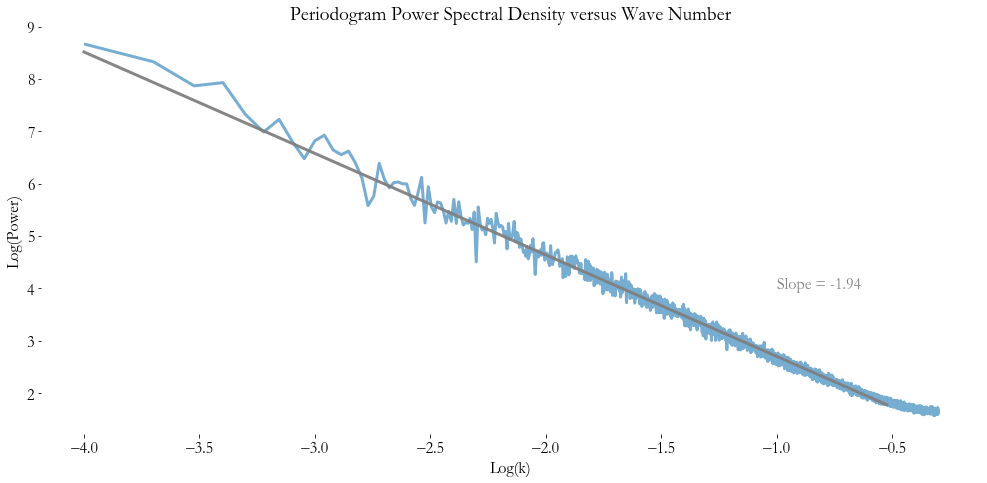

In [13]:
psd_and_slope_plot(samp_sum_list)

Output

In [14]:
np.savetxt(location_out+'Pareto_fault_interface_b_1p5.txt', samp_sum_list)

_________________________________________________________________________________________________________

In [15]:
b = 2.0
print(f'Creating interface with fault throw Pareto distribution with b={b}')

Creating interface with fault throw Pareto distribution with b=2.0


Pareto distribution with parameter b=2.0 summary stats:
Mean: 2.0, var: inf, skew: nan, kurt: nan

Output derived statistics:
DescribeResult(nobs=10000, minmax=(-58.514667745894066, 46.5491903273875), mean=0.04567823399174539, variance=5.085519416735868, skewness=1.6056354705548896, kurtosis=138.19515283845274)



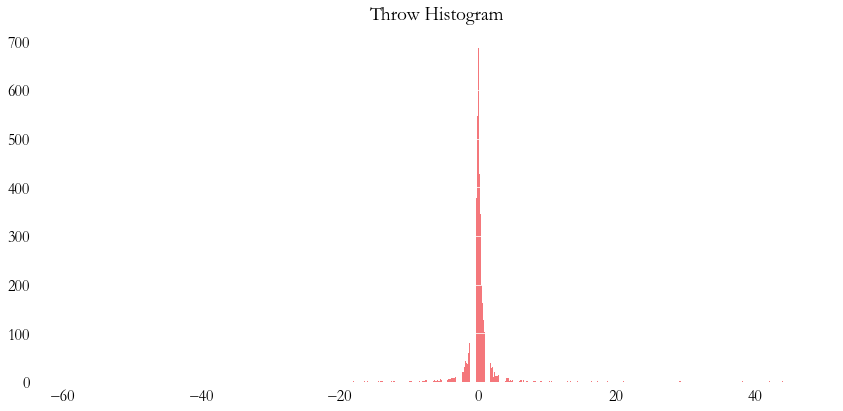

Final number of the random throw, n, is 10000 and spatial grid, i, is 14334


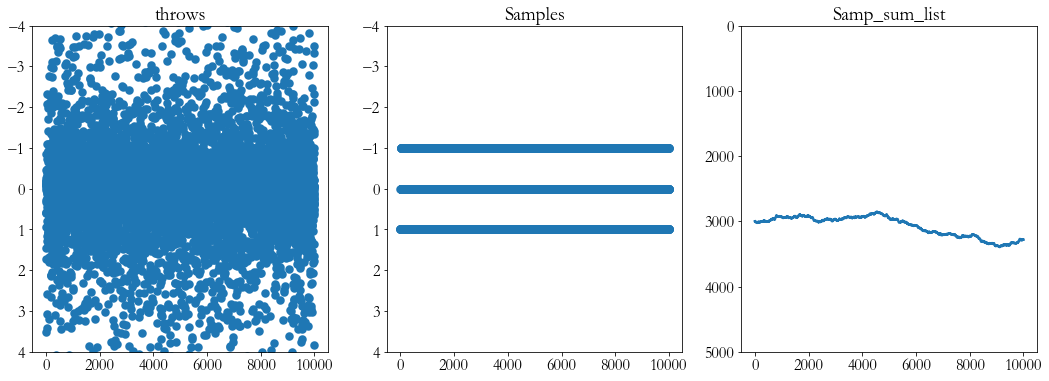

In [16]:
throws = pareto_throw(L=10000, seed=42, b=b, shift=1, pos_def=True)
samples, samp_sum_list = random_interface(D_int=3000, throws=throws)
analysis_plot(throws, samples, samp_sum_list, D_total=5000)

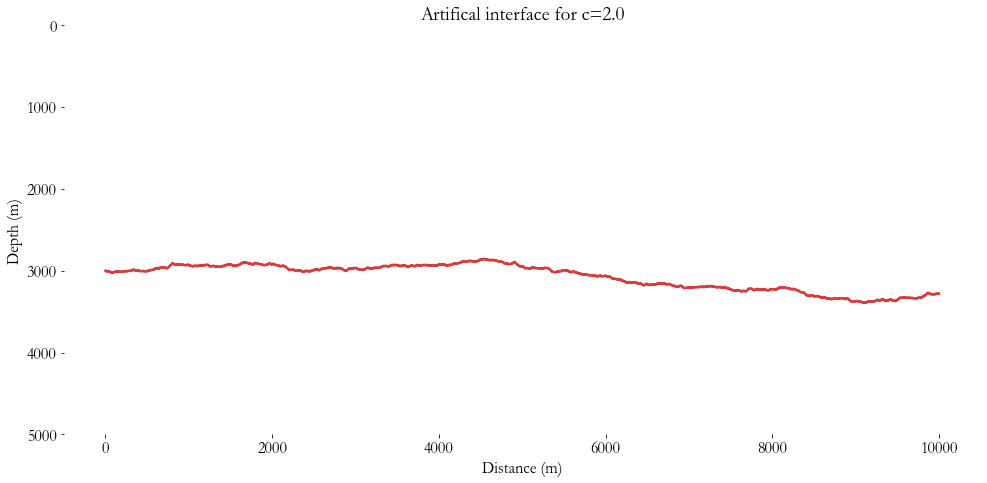

In [17]:
title = 'Artifical interface for c=' + str(b)
single_plot(samp_sum_list, D_total=5000, title=title)

In [18]:
# Statistically derived standard deviation of Samp_sum_list
print('The sample statistics of samp_sum_list (the random interface) are:')
print(stats.describe(samp_sum_list))
print('\n')
#By default scipy.stats works out the sample variance, we want the population variance (so degrees of freedom = 0)
print('The statistics of samp_sum_list (the random interface) calculated as the full population are:')
print(stats.describe(samp_sum_list, ddof=0))

The sample statistics of samp_sum_list (the random interface) are:
DescribeResult(nobs=10000, minmax=(2855.0, 3394.0), mean=3074.0872, variance=24633.01029718972, skewness=0.5745946177246661, kurtosis=-1.126747129584907)


The statistics of samp_sum_list (the random interface) calculated as the full population are:
DescribeResult(nobs=10000, minmax=(2855.0, 3394.0), mean=3074.0872, variance=24630.54699616, skewness=0.5745946177246661, kurtosis=-1.126747129584907)


LinregressResult(slope=-1.9347774473313937, intercept=-0.2886695006760105, rvalue=-0.970732532396615, pvalue=0.0, stderr=0.008742226086059724)
The slope is -1.93


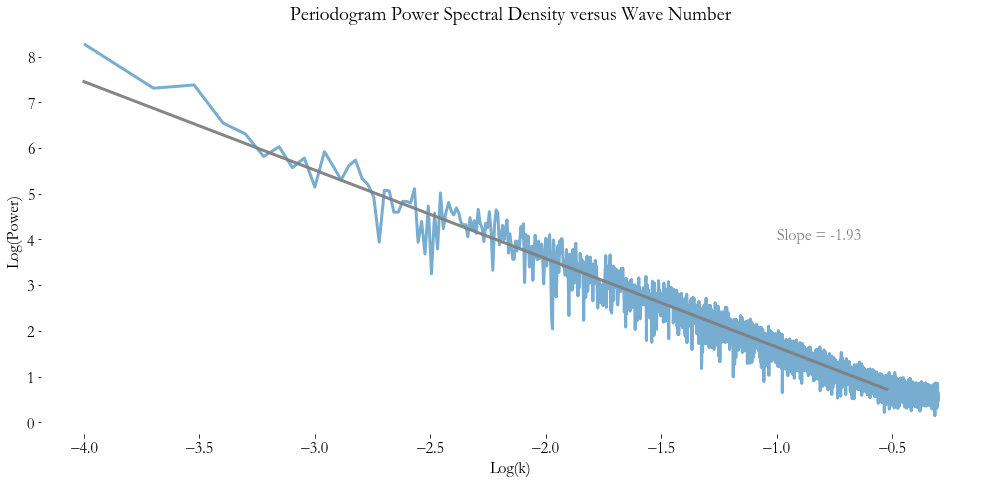

In [19]:
psd_and_slope_plot(samp_sum_list)

Output

In [20]:
np.savetxt(location_out+'Pareto_fault_interface_b_2p0.txt', samp_sum_list)